In [ ]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
# 모델의 reproducibility를 위해 학습 환경 및 random seed 고정
import numpy as np
import tensorflow as tf
import random

seed_num = 256
np.random.seed(seed_num)
random.seed(seed_num)
tf.random.set_seed(seed_num)

from keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1,
                                        inter_op_parallelism_threads = 1)
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
K.set_session(sess)

In [ ]:
#모델 라이브러리 가져오기 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
#import resnet
from tensorflow.keras.applications import resnet50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x_train = np.load('/content/drive/Shareddrives/2022-1 KUBIG 음악추천시스템/melspectogram.npy')

In [ ]:
target = []
for i in range(200):
  target.append(0)
for i in range(200):
  target.append(1)
for i in range(200):
  target.append(2)
for i in range(200):
  target.append(3)

In [ ]:
y_train = np.array(target)

In [ ]:
x_train.shape

x_train= np.concatenate([x_train[0:200], x_train[400:]])

In [ ]:
x_train.shape

(800, 128, 2584)

In [ ]:
import cv2
cv2.resize(x_train[0], (256, 256), interpolation = cv2.INTER_LANCZOS4).shape


from sklearn.preprocessing import StandardScaler

new = []
for i in range(800):
  scaler = StandardScaler()
  temp = scaler.fit_transform(x_train[i])
  new.append(cv2.resize(temp, (256, 256), interpolation = cv2.INTER_LANCZOS4))

In [ ]:
new2 = []
for i in range(800):
  new2.append(np.array([new[i], new[i], new[i]]))

In [ ]:
x_train = np.array(new2)

In [ ]:
x_train.shape

(800, 3, 256, 256)

In [ ]:
x_train = np.swapaxes(np.swapaxes(x_train, 1, 2), 2, 3)

In [ ]:
x_train.shape

(800, 256, 256, 3)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, random_state = 256, test_size = 0.2)

In [ ]:
model=resnet50.ResNet50(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))

for layer in model.layers[:]:
    layer.trainable = False

flattened = tf.keras.layers.Flatten()(model.output)

fc1 = tf.keras.layers.Dense(5, activation='softmax', name="AddedDense2")(flattened)

model = tf.keras.models.Model(inputs=model.input, outputs=fc1) 

In [ ]:
# 모델 컴파일
model.compile(optimizer ='adamax',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

print('Model Details are : ')
print(model.summary())

Model Details are : 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                         

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

kfold = 5
skf = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 256)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping  

In [ ]:
testpred = []
testprob = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    
    print('[Fold %d/%d]' % (i + 1, kfold))
    
    
    trainx, validx = x_train[train_index], x_train[val_index]
    trainy, validy = y_train[train_index], y_train[val_index]

 
    callbacks_list = [  
      ModelCheckpoint('/content/drive/MyDrive/musicrecommendation_resent50withoutdance{zero}.h5'.format(zero = i), monitor='val_accuracy', mode='max', verbose = 1, save_best_only = True),
      EarlyStopping(patience=8, verbose = 1),
      ReduceLROnPlateau(patience=4, verbose=1)
    ]  

    ThisModel = model.fit(trainx, trainy, validation_data = (validx, validy), batch_size=32, epochs=100, callbacks=callbacks_list, verbose=1)

[Fold 1/5]
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 5.9087 - accuracy: 0.4172
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to /content/drive/MyDrive/musicrecommendation_resent50withoutdance0.h5
20/20 [==============================] - 20s 308ms/step - loss: 5.9087 - accuracy: 0.4172 - val_loss: 4.6064 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.6572 - accuracy: 0.5594
Epoch 2: val_accuracy improved from 0.45000 to 0.57500, saving model to /content/drive/MyDrive/musicrecommendation_resent50withoutdance0.h5
20/20 [==============================] - 4s 212ms/step - loss: 2.6572 - accuracy: 0.5594 - val_loss: 1.9843 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.0476 - accuracy: 0.7188
Epoch 3: val_accuracy improved from 0.57500 to 0.65000, saving model to /content/drive/MyDrive/musicrecommendation_resent50withoutdance0.h

In [ ]:
testpred

[array([1, 4, 4, 3, 0, 3, 3, 2, 4, 2, 0, 1, 1, 3, 0, 1, 1, 3, 2, 3, 1, 0,
        0, 4, 1, 0, 0, 4, 4, 3, 1, 3, 4, 1, 2, 2, 0, 2, 0, 1, 3, 2, 1, 0,
        1, 4, 3, 0, 1, 3, 4, 3, 1, 0, 4, 3, 3, 0, 2, 3, 4, 4, 4, 0, 0, 4,
        3, 2, 3, 1, 4, 2, 3, 4, 1, 1, 1, 4, 3, 1, 1, 0, 0, 3, 3, 0, 1, 1,
        0, 0, 1, 1, 3, 4, 1, 3, 1, 4, 2, 0, 0, 3, 1, 0, 1, 2, 3, 3, 3, 0,
        4, 2, 0, 1, 4, 2, 0, 4, 4, 0, 1, 1, 2, 3, 3, 4, 0, 2, 1, 2, 0, 1,
        3, 2, 2, 1, 2, 4, 0, 3, 2, 4, 4, 4, 4, 2, 4, 4, 3, 3, 0, 1, 2, 3,
        2, 4, 2, 0, 0, 4, 4, 0, 0, 4, 4, 4, 1, 0, 2, 2, 4, 4, 1, 2, 1, 3,
        4, 3, 4, 2, 2, 1, 2, 1, 4, 1, 1, 1, 2, 0, 1, 2, 4, 2, 3, 3, 4, 4,
        0, 2]),
 array([1, 4, 4, 3, 0, 3, 3, 2, 4, 2, 0, 1, 1, 3, 0, 1, 1, 3, 2, 3, 1, 0,
        0, 4, 1, 0, 4, 4, 4, 3, 1, 3, 4, 1, 2, 2, 0, 2, 0, 1, 3, 2, 1, 0,
        1, 4, 3, 0, 1, 3, 4, 3, 1, 0, 4, 3, 3, 0, 4, 3, 4, 4, 4, 0, 0, 4,
        3, 2, 3, 1, 4, 2, 4, 4, 1, 1, 4, 4, 3, 1, 1, 0, 0, 3, 3, 0, 1, 1,
        0, 0, 4, 1, 3,

In [ ]:
testprob

[array([[1.12102163e-04, 9.99877810e-01, 6.79827281e-06, 3.03207641e-14,
         3.29020259e-06],
        [2.64150253e-03, 4.14417123e-08, 6.71891263e-03, 1.50691029e-02,
         9.75570381e-01],
        [3.19643950e-05, 7.84309595e-09, 1.03126541e-02, 1.24996970e-03,
         9.88405466e-01],
        [1.58219553e-12, 1.61812841e-09, 6.37356493e-07, 9.99989629e-01,
         9.74611521e-06],
        [8.86638284e-01, 1.11255974e-01, 7.20602184e-05, 8.91083400e-05,
         1.94453995e-03],
        [1.11535684e-07, 4.30014878e-12, 3.59235634e-03, 9.83315468e-01,
         1.30920606e-02],
        [1.89732832e-13, 7.24186227e-13, 1.66141689e-01, 8.29212487e-01,
         4.64583421e-03],
        [1.00974421e-06, 3.58822290e-05, 6.45561814e-01, 2.49373809e-01,
         1.05027482e-01],
        [2.20388740e-01, 1.15046864e-02, 3.55667179e-03, 1.18436443e-03,
         7.63365507e-01],
        [1.51416715e-02, 1.78592411e-04, 9.65041280e-01, 4.25992737e-04,
         1.92124471e-02],
        [9

In [ ]:
for i in range(5):
  sum = 0
  sum_list = []
  for j in range(len(testpred[i])):
    if testpred[i][j] == y_test[j]:
      sum = sum + 1
  print(sum / len(testpred[1]) * 100)
  sum_list.append(sum / len(testpred[1]) * 100)

72.0
71.5
71.5
71.5
71.5


In [ ]:
np.mean(sum_list)

71.5

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve_blue(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='skyblue', alpha = 0.08)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
def plot_roc_curve_red(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 0.08)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
def plot_roc_curve_red_2(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 1)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
classes = [0, 1, 2, 3, 4]
classes

[0, 1, 2, 3, 4]

In [ ]:
classes_names = ['Hip hop', 'Dance', 'Trot', 'Ballad', 'Rock']

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, auc
import seaborn as sns

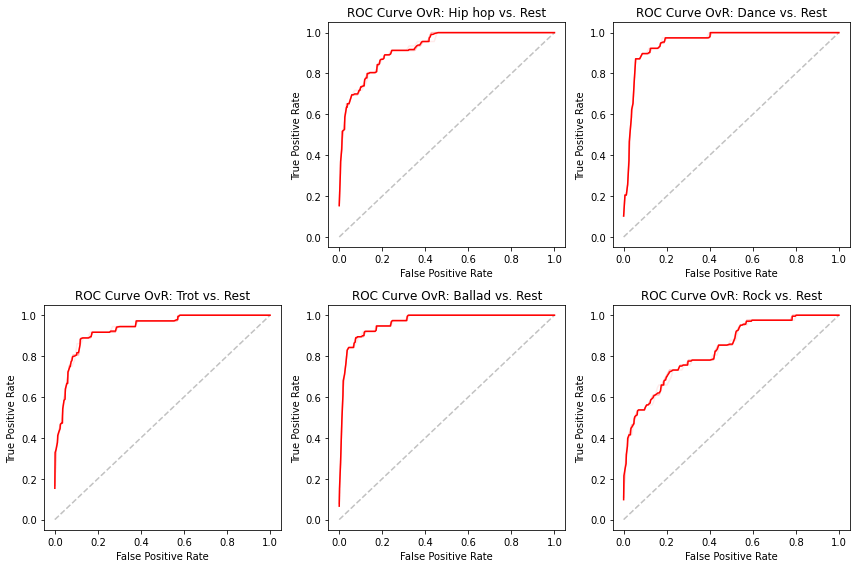

In [ ]:
plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(5):

        c = classes[i]

        df_aux = pd.DataFrame(y_test).copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = np.array(testprob)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+2)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])


        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_red(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plot_roc_curve_red_2(np.sort(np.array(pd.DataFrame(temptpr).mean())), np.sort(np.array(pd.DataFrame(tempfpr).mean())), scatter = False, ax = ax_bottom)

    plt.tight_layout()

In [ ]:
auc[:5]

[0.9247600225861096,
 0.9243365330321852,
 0.9241953698475438,
 0.9241953698475438,
 0.9241953698475438]

In [ ]:
np.mean(auc[:5])

0.9243365330321852

In [ ]:
auc[5:10]

[0.9531772575250836,
 0.9522216913521261,
 0.9522216913521261,
 0.9522216913521261,
 0.9522216913521261]

In [ ]:
np.mean(auc[5:10])

0.9524128045867176

In [ ]:
auc[10:15]

[0.9324186991869918,
 0.9317411924119241,
 0.9317411924119241,
 0.9317411924119241,
 0.9317411924119241]

In [ ]:
np.mean(auc[10:15])

0.9318766937669377

In [ ]:
auc[15:20]

[0.9636127355425601,
 0.9636127355425601,
 0.9636127355425601,
 0.9636127355425601,
 0.9636127355425601]

In [ ]:
np.mean(auc[15:20])

0.96361273554256

In [ ]:
auc[20:25]

[0.8283479061205706,
 0.8321828501303881,
 0.8323362478907808,
 0.8323362478907808,
 0.8323362478907808]

In [ ]:
np.mean(auc[20:25])

0.8315078999846601

In [ ]:
totalauc = [np.mean(auc[:5]), np.mean(auc[5:10]), np.mean(auc[10:15]), np.mean(auc[15:20]), np.mean(auc[20:25])]
np.mean(totalauc)

0.9207493333826122

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

sens0 = []
spec0 = []
sens1 = []
spec1 = []
sens2 = []
spec2 = []
sens3 = []
spec3 = []
sens4 = []
spec4 = []

for i in range(5):
    for l in [0, 1, 2, 3, 4]:
        prec, recall, _, _ = precision_recall_fscore_support(np.array(y_test) == l, testpred[i] == l, pos_label = True, average = None)
        if l == 0:
            sens0.append(recall[0])
            spec0.append(recall[1])
        elif l == 1:
            sens1.append(recall[0])
            spec1.append(recall[1])
        elif l == 2:
            sens2.append(recall[0])
            spec2.append(recall[1])
        elif l == 3:
            sens3.append(recall[0])
            spec3.append(recall[1])
        else:
            sens4.append(recall[0])
            spec4.append(recall[1])
            
df = [[np.mean(sens0), np.mean(spec0)], [np.mean(sens1), np.mean(spec1)], [np.mean(sens2), np.mean(spec2)], [np.mean(sens3), np.mean(spec3)], [np.mean(sens4), np.mean(spec4)]]
print(pd.DataFrame(df))
print(pd.DataFrame(df).mean(axis=0))

     0    1
0 0.95 0.65
1 0.94 0.83
2 0.94 0.67
3 0.96 0.82
4 0.84 0.62
0   0.93
1   0.72
dtype: float64


In [ ]:
## simplernn
## lstm
## gru

## resnet50
## inception / xception
## senet (그냥...)
## vision transformer

## cosine similiarity
## p-norm


## 1. 본인 장르 30개 더
## 2. 7788 / 상준 승은 지호 지우
## 3. 지호 지우 추천시스템 (함수 만들기) - cv 모델 느낌만
## 4. 상준 승은 다 하기